# Face Recognition: Look How Far We've Come

In this notebook, I hope to show the first step of the progression, together with its consequent results, in facial recognition.   Facial recognition is itself a rather developed specialty within computer vision ("CV"), and CV, in turn, is a substantial subset of Artificial Intelligence ("AI".)   As such, I do not intend for these notebooks, alone or together with the accompanying report, to be an all-encompassing historical account.   Rather, I intend for this to show, by way of examples, a few milestones.   Specifically I start with the canonical Eigenfaces problem, together with its dataset and solution employing principal component analysis ("PCA") and a support vector machine ("SVM") classifier in this notebook.   I then move on to the Haar cascades approach in the second notebook.  Finally, I explore deep learning ("DL") algorithms as a solutions in the third and fourth notebooks.

# Solution 1.  The canonical Eigenfaces problem, dataset, and PCA-SVM solution 

Directly from: http://scikit-learn.org/stable/auto_examples/applications/plot_face_recognition.html
For attribution please see report.pdf accompanying this notebook.

In [1]:
%matplotlib inline
from time import time
import logging
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC

# At the end of this notebook important information is persisted (to file) for later use,
# requiring the below libraries, which are in addition to those needed by this canned dataset and lesson
import pickle as pkl
import os
from os.path import expanduser, isfile

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [2]:
# Display progress logs on stdout
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')

In [3]:
# Download the data, if not already on disk and load it as numpy arrays
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape

# for machine learning we use the 2 data directly (as relative pixel positions info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7


In [4]:
# Split into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)

In [5]:
# Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
# dataset): unsupervised feature extraction / dimensionality reduction
n_components = 150

print("Extracting the top %d eigenfaces from %d faces" % (n_components, X_train.shape[0]))
t0 = time()
pca = PCA(n_components=n_components, svd_solver='randomized', whiten=True).fit(X_train)
print("done in %0.3fs" % (time() - t0))

eigenfaces = pca.components_.reshape((n_components, h, w))

print("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print("done in %0.3fs" % (time() - t0))

Extracting the top 150 eigenfaces from 966 faces
done in 0.142s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.013s


In [6]:
# Train a SVM classification model

print("Fitting the classifier to the training set")
t0 = time()
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5], 'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
clf = clf.fit(X_train_pca, y_train)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)

Fitting the classifier to the training set
done in 24.712s
Best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [7]:
# Quantitative evaluation of the model quality on the test set

print("Predicting people's names on the test set")
t0 = time()
y_pred = clf.predict(X_test_pca)
print("done in %0.3fs" % (time() - t0))

print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))

Predicting people's names on the test set
done in 0.053s
                   precision    recall  f1-score   support

     Ariel Sharon       0.56      0.69      0.62        13
     Colin Powell       0.73      0.87      0.79        60
  Donald Rumsfeld       0.76      0.81      0.79        27
    George W Bush       0.92      0.87      0.89       146
Gerhard Schroeder       0.83      0.80      0.82        25
      Hugo Chavez       0.73      0.53      0.62        15
       Tony Blair       0.85      0.78      0.81        36

      avg / total       0.83      0.83      0.83       322

[[  9   1   2   1   0   0   0]
 [  2  52   1   4   0   1   0]
 [  4   1  22   0   0   0   0]
 [  1  11   2 127   2   1   2]
 [  0   2   0   1  20   1   1]
 [  0   2   0   2   1   8   2]
 [  0   2   2   3   1   0  28]]


In [8]:
# Qualitative evaluation of the predictions using matplotlib

def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

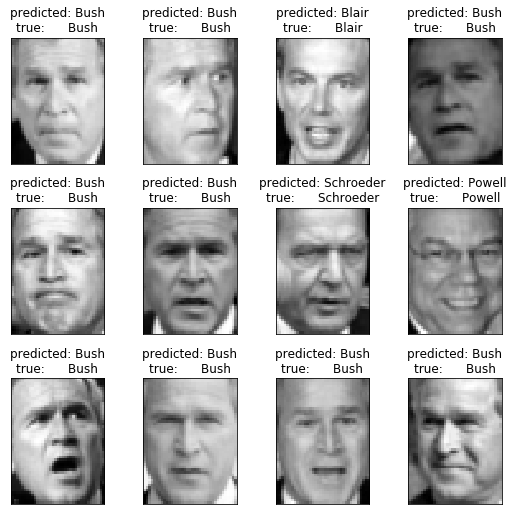

In [9]:
# plot the result of the prediction on a portion of the test set

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)

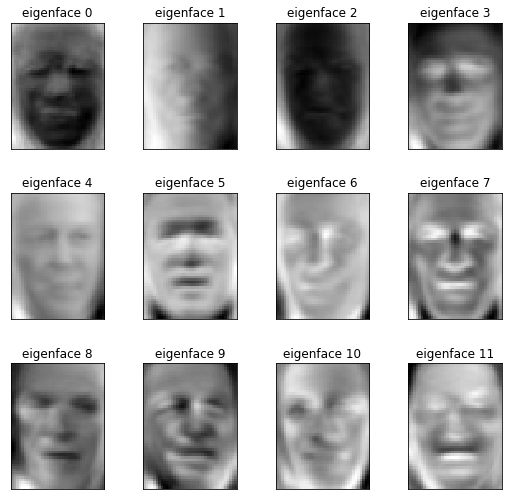

In [10]:
# plot the gallery of the most significative eigenfaces

eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

plt.show()

In [11]:
# Let's capture a few things for later use/steps and persist them

home_dir = expanduser('~')
lfw_img_dir = '/scikit_learn_data/lfw_home/lfw_funneled/' # I've opted for the default destination folder
image_3D_dir = home_dir + lfw_img_dir
os.chdir(home_dir)
project_folder = 'mlnd-capstone' # THIS MUST BE CREATED BEFORE RUNNING THIS NOTEBOOK, & THIS NOTEBOOK MUST BE IN IT!
project_path = os.getcwd() + project_folder
os.chdir(project_folder)
with open('pic_dir.pickle', 'wb') as picture_path:
    pkl.dump(image_3D_dir, picture_path, protocol=pkl.HIGHEST_PROTOCOL)
    pkl.dump(home_dir, picture_path, protocol=pkl.HIGHEST_PROTOCOL)
    pkl.dump(lfw_img_dir, picture_path, protocol=pkl.HIGHEST_PROTOCOL)
    pkl.dump(project_folder, picture_path, protocol=pkl.HIGHEST_PROTOCOL)
    pkl.dump(project_path, picture_path, protocol=pkl.HIGHEST_PROTOCOL)

# On to Solution 2 (Part 2), haar_face_sol2.ipynb